# Cluster Peaks

Cluster peaks for each cell cluster and look for motifs.

In [2]:
library(DESeq2)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(parallel)

In [3]:
cts <- read.csv("../20200122_snapATAC/snapATAC_sessions/20200125_n76770/cluster_bulk_peakset_matrix/cluster.bulk.idr.cluster.counts.txt",sep="\t")
rownames(cts)=paste(cts$chr,cts$start,cts$end,sep='\t')
cts$chrom = NULL
cts$start = NULL
cts$end = NULL
head(cts, 2)
dim(cts)

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12,cluster13,cluster14,cluster15,cluster16,cluster17,cluster18
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1 51459 51659,1,0,3,2,0,0,0,0,0,2,0,0,3,2,0,0,0,1
chr1 51689 51889,2,1,17,15,0,1,0,0,0,0,2,0,7,1,3,0,0,0


[1] 299032     18

In [4]:
cts = cts[rowSums(cts)>50, ]
dim(cts)

[1] 292377     18

In [5]:
# norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts[rowSums(cts<50)==0, ]))
norm_cts = t(t(cts)/estimateSizeFactorsForMatrix(cts))

In [6]:
log_norm_cts = log10(1+norm_cts)

In [7]:
library(RColorBrewer)

In [8]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [9]:
pca = prcomp(t(log_norm_cts),center=TRUE,scale=FALSE)
pcs=data.frame(pca$x)
pcs$ID=rownames(pcs)
pcs$clust_num = as.numeric(lapply(strsplit(pcs$ID, 'cluster'), "[[",2 ))
var_explained=round(100*pca$sdev^2/sum(pca$sdev^2),2)
print(var_explained)

 [1] 48.60 20.75  7.44  4.91  3.90  3.53  2.54  1.89  1.34  1.01  0.95  0.76
[13]  0.63  0.55  0.49  0.43  0.30  0.00


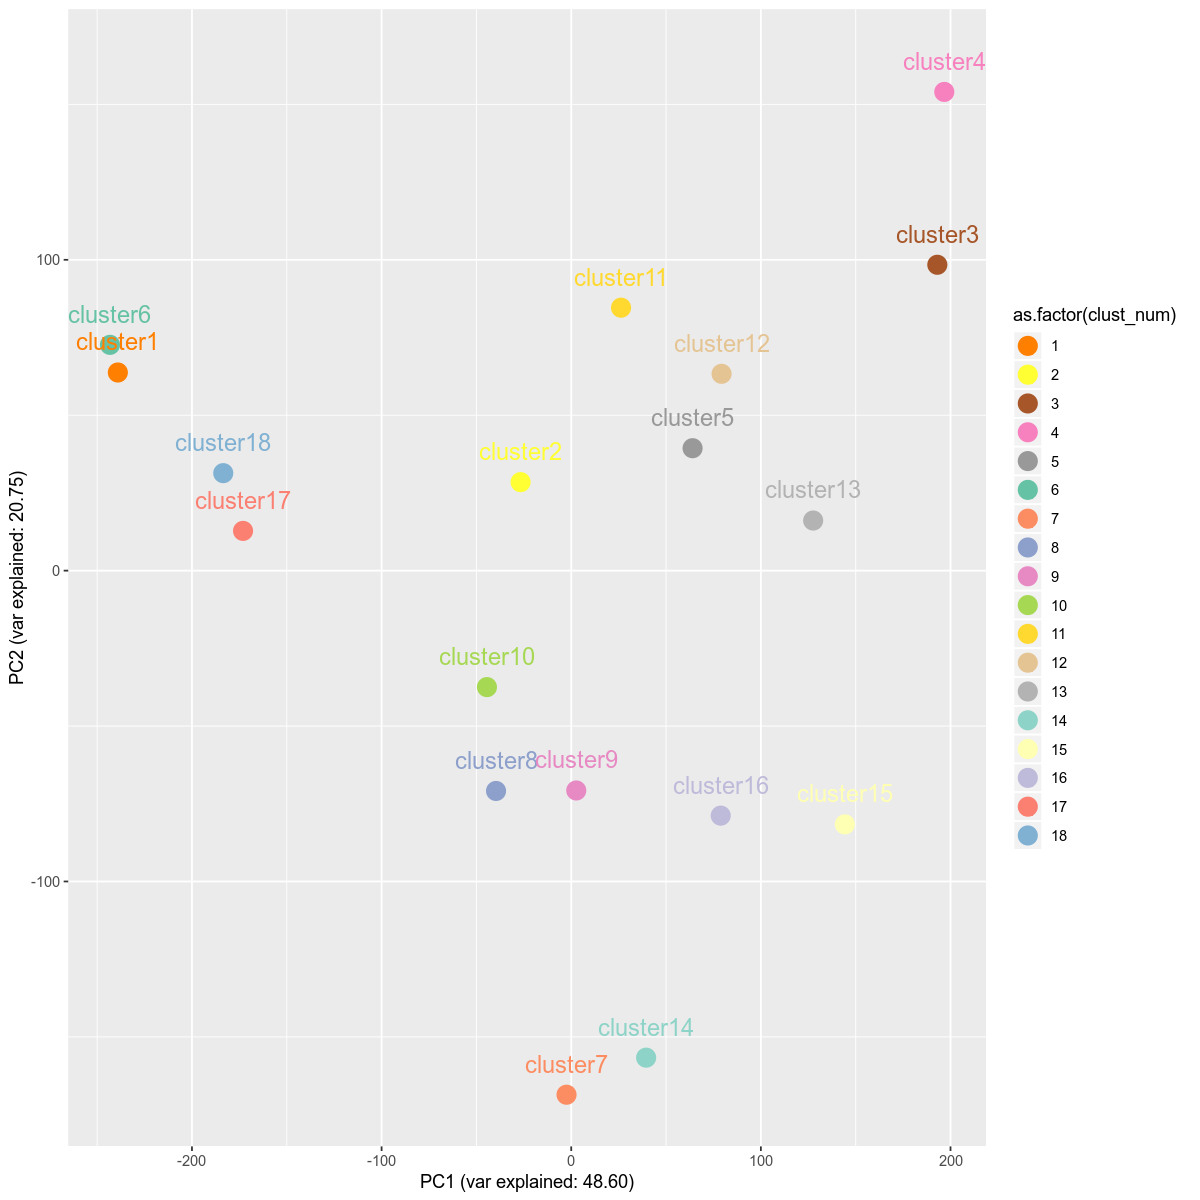

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data=pcs,aes(x=PC1,y=PC2,color=as.factor(clust_num),label=ID))+
geom_point(size=5)+
scale_colour_manual(values = col_vector[seq(50,67)]) +
geom_text(size=5, nudge_y=10)+
labs(x=sprintf("PC1 (var explained: %.2f)", var_explained[1]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

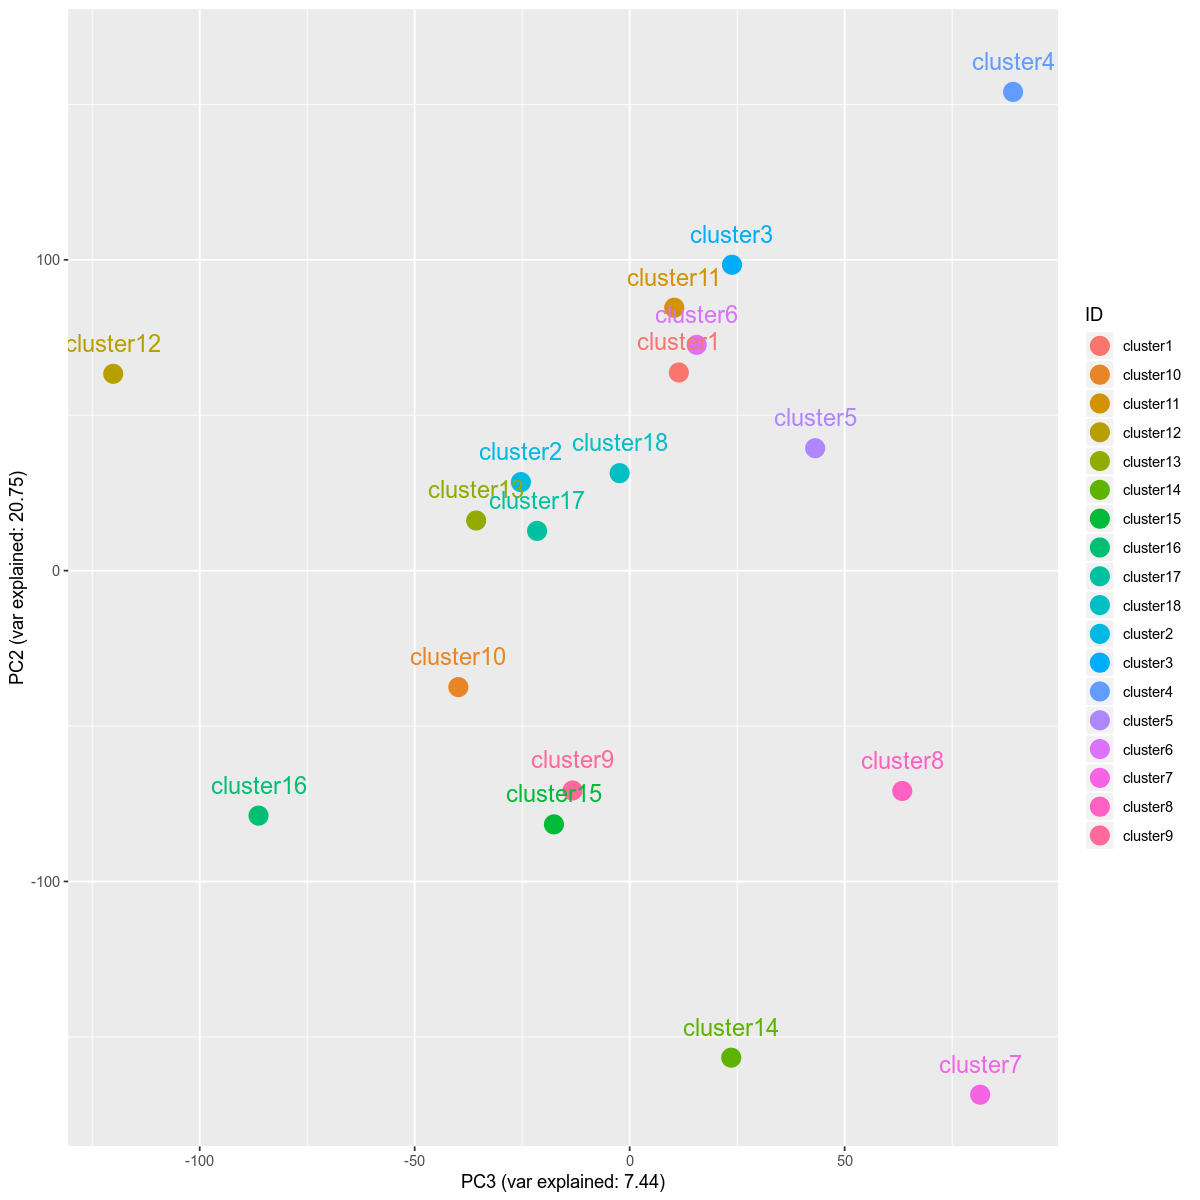

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(data=pcs,aes(x=PC3,y=PC2,color=ID,label=ID))+
geom_point(size=5)+
geom_text(size=5, nudge_y=10)+
labs(x=sprintf("PC3 (var explained: %.2f)", var_explained[3]), y = sprintf("PC2 (var explained: %.2f)", var_explained[2]))

## Diff Peaks

In [47]:
library(edgeR)

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:DESeq2’:

    plotMA


The following object is masked from ‘package:BiocGenerics’:

    plotMA




In [12]:
data.use = cts
group = factor(seq(1,ncol(data.use)))
design = model.matrix(~group)
y = DGEList(counts=data.use, group=group)

In [13]:
# do pairwise comparisons and get union of top diff peaks
all_pairs = vector(mode = "list", length = ncol(cts)*(ncol(cts)-1)/2)
c = 1
for (i in seq(1,ncol(cts))) {
    if (i < ncol(cts)) {
        for (j in seq(i+1, ncol(cts))) {
            all_pairs[[c]] = c(i,j)
            c = c+1
        }
    }
}

PER_PAIR = 10000

get_diff <- function(i, all_pairs, y, per_pair) {
    et = exactTest(y, dispersion = 0.4^2, pair = all_pairs[[i]])         
    cur_diff_peaks = rownames(et$table[order(et$table$PValue)[1:per_pair],])        
}

diff_peaks_list = mclapply(seq(1, length(all_pairs)), 
                           get_diff, 
                           all_pairs=all_pairs, 
                           y=y,  
                           per_pair=PER_PAIR,
                           mc.cores=40)

In [14]:
diff_peak_set = unique(unlist(diff_peaks_list))
length(diff_peak_set)

[1] 152315

## Clustering

In [13]:
library(ClusterR)
library(viridis)
library(scales)

Loading required package: gtools

Loading required package: viridisLite


Attaching package: ‘scales’


The following object is masked from ‘package:viridis’:

    viridis_pal




In [34]:
cts_to_cluster = t(scale(t(log_norm_cts[, ])))
cts_to_cluster = cts_to_cluster[, c("cluster1", "cluster6")]

# cts_to_cluster = log_norm_cts[, c("cluster1", "cluster6")]

In [35]:
# ADD RAND SEED - not required

km_mb = MiniBatchKmeans(cts_to_cluster, 
                        batch_size = 1000,
                        clusters=10,
                        num_init = 10, 
                        verbose = FALSE)

In [36]:
# reorder based on hierarchical clustering
pr_mb = predict_MBatchKMeans(cts_to_cluster, km_mb$centroids)
# distance    = dist(km_mb$centroids)
distance    = dist(t(scale(t(km_mb$centroids))))
cluster     = hclust(distance, method="ward")
dendrogram  = as.dendrogram(cluster)
rowInd = rev(order.dendrogram(dendrogram))
pr_mb = order(rowInd)[pr_mb]

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



In [37]:
table(pr_mb)

pr_mb
    1     2     3     4     5     6     7     8     9    10 
20976 29372 28271 33265 28351 29539 28095 26758 24523 43227 

In [38]:
cts_clustered = cts_to_cluster[order(pr_mb),]
head(cts_clustered, 2)

,cluster1,cluster6
chr1 180686 181019,0.6887781,0.9692819
chr1 267909 268125,0.6671996,1.9553341


In [39]:
# order columns
col_distance = dist(t(cts_clustered))
col_cluster = hclust(col_distance, method="ward")
col_dendrogram = as.dendrogram(col_cluster)
colInd = rev(order.dendrogram(col_dendrogram))

cts_clustered_col_ordered = cts_clustered[, colInd]
head(cts_clustered_col_ordered, 2)

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



,cluster6,cluster1
chr1 180686 181019,0.9692819,0.6887781
chr1 267909 268125,1.9553341,0.6671996


In [40]:
# cts_clustered_col_ordered = cts_clustered_col_ordered[,
#                                                       c("cluster1", "cluster18", "cluster8", "cluster7", "cluster4")]
# cts_clustered_col_ordered = cts_clustered_col_ordered[,c("cluster1", "cluster7", "cluster8", "cluster10")]

## Plotting

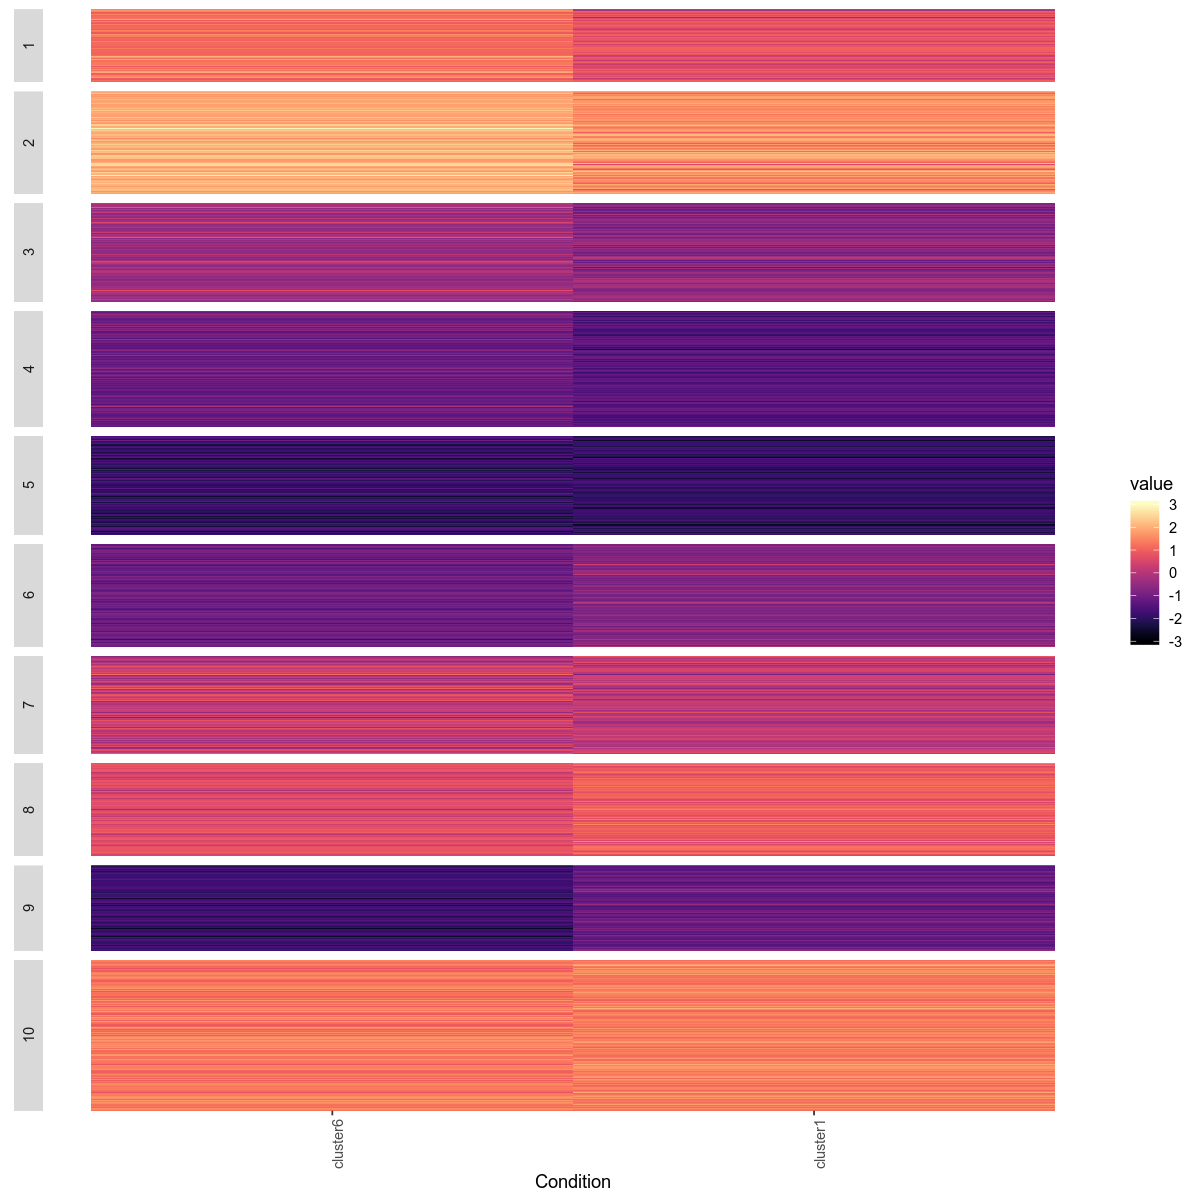

In [42]:
options(repr.plot.width = 10, repr.plot.height = 10)

idxs = seq(1, nrow(cts_clustered_col_ordered), 10) # if subsample
ggplot(data = melt(cts_clustered_col_ordered[idxs,]), mapping = aes(x = Var2,
                                                         y = Var1,
                                                         fill = value)) +
geom_tile()  + ylab(NULL) + xlab("Condition") +  
geom_raster(aes(fill=value)) +
scale_fill_viridis(limits=c(-3, 3), oob=squish, option = "A") +
# scale_fill_viridis(option="A") + 
# scale_fill_gradient2(low="red", mid="black", high="blue") +
facet_grid(sort(pr_mb)[idxs] ~ ., switch = "y", scales = "free_y", space = "free_y")+
# theme_classic() +
theme(axis.text.x=element_text(angle=90,hjust=1),
      axis.text.y=element_blank(),
      axis.ticks.y=element_blank())
#       panel.spacing.y = unit(0.03, "cm"),
#       strip.text.y = element_text(size = 3))  
#       strip.background = element_rect(size = 0.1))

# ggsave(sprintf("figs/%s_heatmap_idr_znorm_n%d.jpeg", format(Sys.Date(), format='%Y%m%d'), length(table(pr_mb))),
#        dpi=1000)

In [51]:
# See distribution of scores
# hist(cts_clustered_col_ordered)

Warning message:
“Removed 7481 rows containing non-finite values (stat_binhex).”


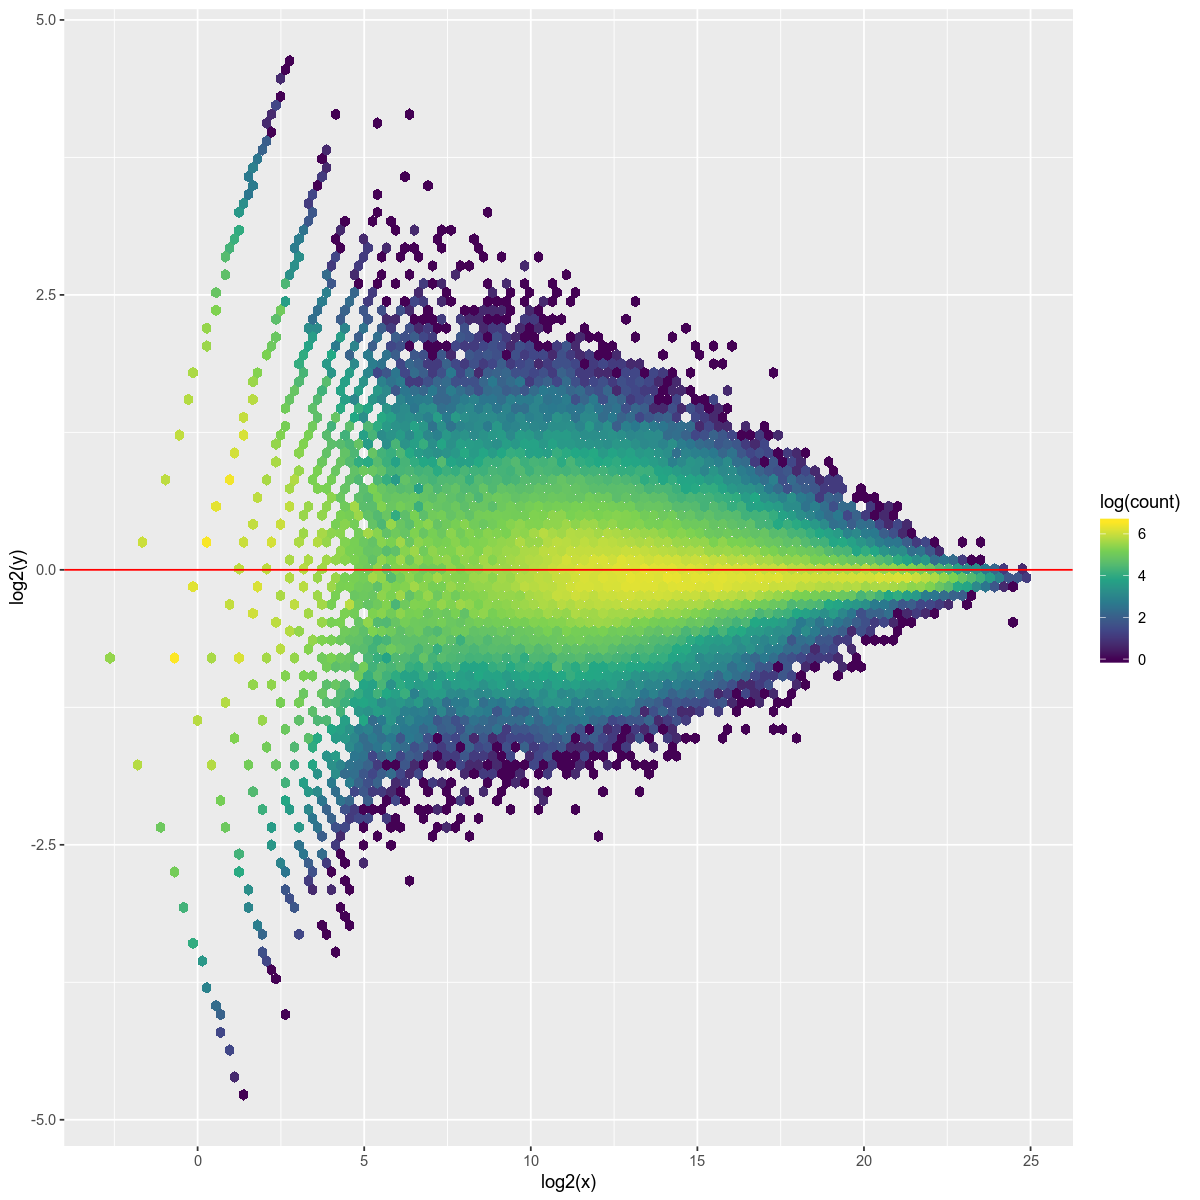

In [64]:
plot_lfc <- function(norm_matrix, S1, S2) {
    df = data.frame(y=(norm_matrix[,S1]/norm_matrix[,S2]),
                x=((norm_matrix[,S1]*norm_matrix[,S2])/2))
    p <- ggplot(df, aes(x=log2(x), y=log2(y))) + 
    # geom_point(alpha=0.1) +
    stat_binhex(aes(fill=log(..count..)), bins=100)+
    scale_fill_viridis_c() + 
#     coord_cartesian(xlim=c(0, 8)) +
    geom_abline(slope=0, col="red")
    p
}

# seems like iPSCs have more open sites...check diff peaks!
plot_lfc(norm_cts, "cluster1", "cluster6")

## Writing BED files for some clusters

In [43]:
CLUSTER_IDX = 1
NORM = 'heatmap_idr_temp'
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), CLUSTER_IDX)
# rownames(vsd_assay_to_cluster_normalized)[(which(pr_mb==CLUSTER_IDX))]
BED_PATH

[1] "beds/20200222_heatmap_idr_temp_n10/idx1.bed"

In [44]:
for (i in seq(1,length(table(pr_mb)))){
BED_PATH = sprintf("beds/%s_%s_n%d/idx%d.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)), i)
fileConn = file(BED_PATH)
writeLines(rownames(cts_to_cluster)[(which(pr_mb==i))], fileConn)
close(fileConn)}

In [45]:
ALL_PEAKS_BED_PATH = sprintf("beds/%s_%s_n%d/all_peaks.bed", format(Sys.Date(), format='%Y%m%d'), NORM, length(table(pr_mb)))
print(ALL_PEAKS_BED_PATH)
fileConn = file(ALL_PEAKS_BED_PATH)
writeLines(rownames(cts_to_cluster), fileConn)
close(fileConn)

[1] "beds/20200222_heatmap_idr_temp_n10/all_peaks.bed"


Commands for motif analysis:

```EXP=20200130_heatmap_idr_n20; for i in {1..4} ; do if [ ! -d homer/$EXP/idx$i ] ; then findMotifsGenome.pl beds/$EXP/idx$i.bed ~/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta homer/$EXP/idx$i -nomotif -size given -bg beds/$EXP/all_peaks.bed -p 8 ; fi ; done```

## GREAT Analysis

In [86]:
library(rGREAT)


------------------
Note: On Aug 19 2019 GREAT released version 4 where it supports `hg38`
genome and removes some ontologies such pathways. `submitGreatJob()`
still takes `hg19` as default. `hg38` can be specified by the `species
= 'hg38'` argument. To use the older versions such as 3.0.0, specify as
`submitGreatJob(..., version = '3.0.0')`.
------------------



In [165]:
peaks = read.table("beds/20200222_heatmap_idr_temp_n10/clus1_up_5000.bed")
colnames(peaks) = c("chr", "start", "end")
peaks = makeGRangesFromDataFrame(peaks)
peaks

GRanges object with 5000 ranges and 0 metadata columns:
         seqnames            ranges strand
            <Rle>         <IRanges>  <Rle>
     [1]    chr11 88975486-88975702      *
     [2]    chr14 87869713-87869924      *
     [3]    chr10 64354613-64355066      *
     [4]    chr13 90792380-90792603      *
     [5]    chr15 25611636-25611940      *
     ...      ...               ...    ...
  [4996]     chr3 42138068-42138454      *
  [4997]     chr3 43675595-43675795      *
  [4998]     chr3 50901094-50901362      *
  [4999]     chr3 54649313-54649522      *
  [5000]     chr3 58749436-58749791      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [173]:
bg = read.table("beds/20200222_heatmap_idr_temp_n10/all_peaks.bed")
colnames(bg) = c("chr", "start", "end")
bg = makeGRangesFromDataFrame(bg)
bg

GRanges object with 292377 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1       51909-52109      *
       [2]     chr1     180686-181019      *
       [3]     chr1     181029-181260      *
       [4]     chr1     181326-181580      *
       [5]     chr1     191417-191618      *
       ...      ...               ...    ...
  [292373]     chrY 20925381-20925700      *
  [292374]     chrY 26670528-26670881      *
  [292375]     chrY 26670911-26671111      *
  [292376]     chrY 26671305-26671505      *
  [292377]     chrY 56734685-56734890      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [178]:
job = submitGreatJob(peaks, bg=bg, species = "hg38", request_interval = 10)

In [179]:
job

Submit time: 2020-02-22 16:43:55 
Version: 4.0.4 
Species: hg38 
Inputs: 5000 regions
Background: user-defined, 292377 regions
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  None


In [180]:
tb = getEnrichmentTables(job)
names(tb)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

In [181]:
head(tb[[2]][tb[[2]]$Hyper_Fold_Enrichment>1, c(1,2,3,4,6,13)], 30)
# head(tb[[2]][(tb[[2]]$Hyper_Expected<1000)&(tb[[2]]$Hyper_Fold_Enrichment>2), c(1,2,3,4,6,13)], 30)

# head(tb[[2]][(tb[[2]]$Binom_Expected<1000)&(tb[[2]]$Binom_Fold_Enrichment>2), ], 30)
# head(tb[[2]], 30)

,ID,name,Hyper_Total_Regions,Hyper_Expected,Hyper_Fold_Enrichment,Hyper_Adjp_BH
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,GO:0051965,positive regulation of synapse assembly,3801,65.001690,1.738416,0.0003333098
2,GO:0021953,central nervous system neuron differentiation,8958,153.192600,1.442628,0.0003761445
3,GO:0006683,galactosylceramide catabolic process,77,1.316793,8.353629,0.0003761445
4,GO:0007417,central nervous system development,37386,639.345800,1.190279,0.0007136787
5,GO:0048712,negative regulation of astrocyte differentiation,540,9.234653,3.032058,0.0009215974
6,GO:0046477,glycosylceramide catabolic process,95,1.624615,6.770836,0.0015362647
7,GO:0018315,molybdenum incorporation into molybdenum-molybdopterin complex,97,1.658817,6.631231,0.0015362647
8,GO:0072579,glycine receptor clustering,97,1.658817,6.631231,0.0015362647
9,GO:0046479,glycosphingolipid catabolic process,144,2.462574,5.279029,0.0020255546
